In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from src.ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCNN_Inception_module-v2-reduced-no-inception-noBN"


/home/jelinek/recetox/src/notebooks/model_heaven


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), activation='relu', padding='same')(inputs)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)

        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), activation='relu', padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 

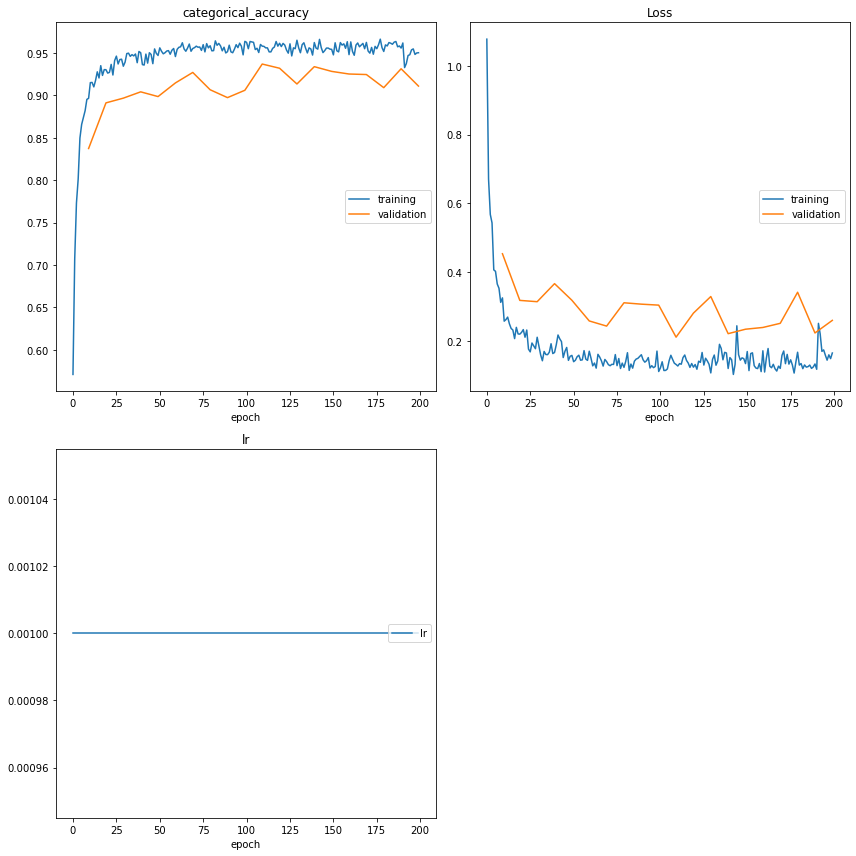

categorical_accuracy
	training         	 (min:    0.571, max:    0.966, cur:    0.950)
	validation       	 (min:    0.837, max:    0.937, cur:    0.911)
Loss
	training         	 (min:    0.102, max:    1.078, cur:    0.164)
	validation       	 (min:    0.210, max:    0.453, cur:    0.259)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
102/102 [==============================] - 6s 62ms/step - loss: 0.2592 - categorical_accuracy: 0.9109
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4561ms
Confusion Matrix
[[317   3   1   0   1   0   0   0   0   0  13   0]
 [  2  45  12   1   1   0   2   1   0   0   0   0]
 [  5   2 134   0   2   0   0   2   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  0   1   2   2 538   0   0   0   0   0   1   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   4   2   0   0   0  68   3   0   0   0   0]
 [  1   1   1   0   0   0   2  81   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0 

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1617 images belonging to 12 classes.
102/102 [==============================] - 6s 58ms/step - loss: 0.2592 - categorical_accuracy: 0.9109
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4028ms
Confusion Matrix
[[317   3   1   0   1   0   0   0   0   0  13   0]
 [  2  45  12   1   1   0   2   1   0   0   0   0]
 [  5   2 134   0   2   0   0   2   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  0   1   2   2 538   0   0   0   0   0   1   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   4   2   0   0   0  68   3   0   0   0   0]
 [  1   1   1   0   0   0   2  81   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [  8   0   1   0   3   0   0   0   0   0 222   0]
 [ 20   0   0   0   1   0   0   0   0   0  40  57]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.90      0.95      0.9

In [7]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)